In [72]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from astroML.utils.decorators import pickle_results

import time

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [73]:
file = '../solutions/galaxyquasar.csv'
data = np.genfromtxt(file, delimiter=',', dtype = str)
print(data)

[['u' 'g' 'r' ... 'class' 'z1' 'zerr']
 ['18.97213' '18.53676' '18.5828' ... 'QSO' '0.5228189' '0.0001547483']
 ['19.24592' '17.47646' '16.47817' ... 'GALAXY' '0.1228459'
  '2.816076E-05']
 ...
 ['18.62718' '17.30876' '16.87371' ... 'GALAXY' '0.05442934'
  '8.433598E-06']
 ['19.5514' '18.27711' '17.62101' ... 'GALAXY' '0.1125709' '9.286238E-06']
 ['18.80772' '17.75751' '17.405' ... 'GALAXY' '0.04365238' '7.415751E-06']]


In [74]:
def rescale(x): 
    #rescale between -1 and 1
    x_max = x.max()
    x_min = x.min()
    
    return  1 - 2 * (x - x_min) / (x_max - x_min)

In [75]:
#colors
ug = data[1:,0].astype(float) - data[1:,1].astype(float)
ug = rescale(ug)
gr = data[1:,1].astype(float) - data[1:,2].astype(float)
gr = rescale(gr)
ri = data[1:,2].astype(float) - data[1:,3].astype(float)
ri = rescale(ri)
iz = data[1:,3].astype(float) - data[1:,4].astype(float)
iz = rescale(iz)

galaxies = data[1:,0:4][data[1:,5]=='GALAXY'].astype(float)
quasars = data[1:,0:4][data[1:,5]=='QSO'].astype(float)

labels = np.char.replace(data[1:,5], 'GALAXY', '0')
labels = np.char.replace(labels, 'QSO', '1').astype(float)

In [76]:
ug_train, ug_test, gr_train, gr_test, ri_train, ri_test, iz_train, iz_test, labels_train, labels_test = train_test_split(ug, gr, ri, iz, labels, test_size=0.3, random_state=42)

In [77]:
colors_train = np.column_stack((ug_train, gr_train, ri_train, iz_train))
colors_test = np.column_stack((ug_test, gr_test, ri_test, iz_test))

In [78]:
def return_accuracy(pred, test):
    true = len(pred[pred == test])
    return true / len(test)

In [136]:
accuracy = []

In [137]:
clf = MLPClassifier(hidden_layer_sizes=(5), activation='relu', solver='adam', learning_rate='constant', learning_rate_init=0.001)
clf.fit(colors_train, labels_train)

MLPClassifier(hidden_layer_sizes=5)

In [138]:
labels_pred = clf.predict(colors_test)
proba = clf.predict_proba(colors_test)[:,1]
fpr, tpr, thresh = roc_curve(labels_test, proba)

In [139]:
acc = return_accuracy(labels_pred, labels_test)
accuracy.append(acc)
acc

0.9815333333333334

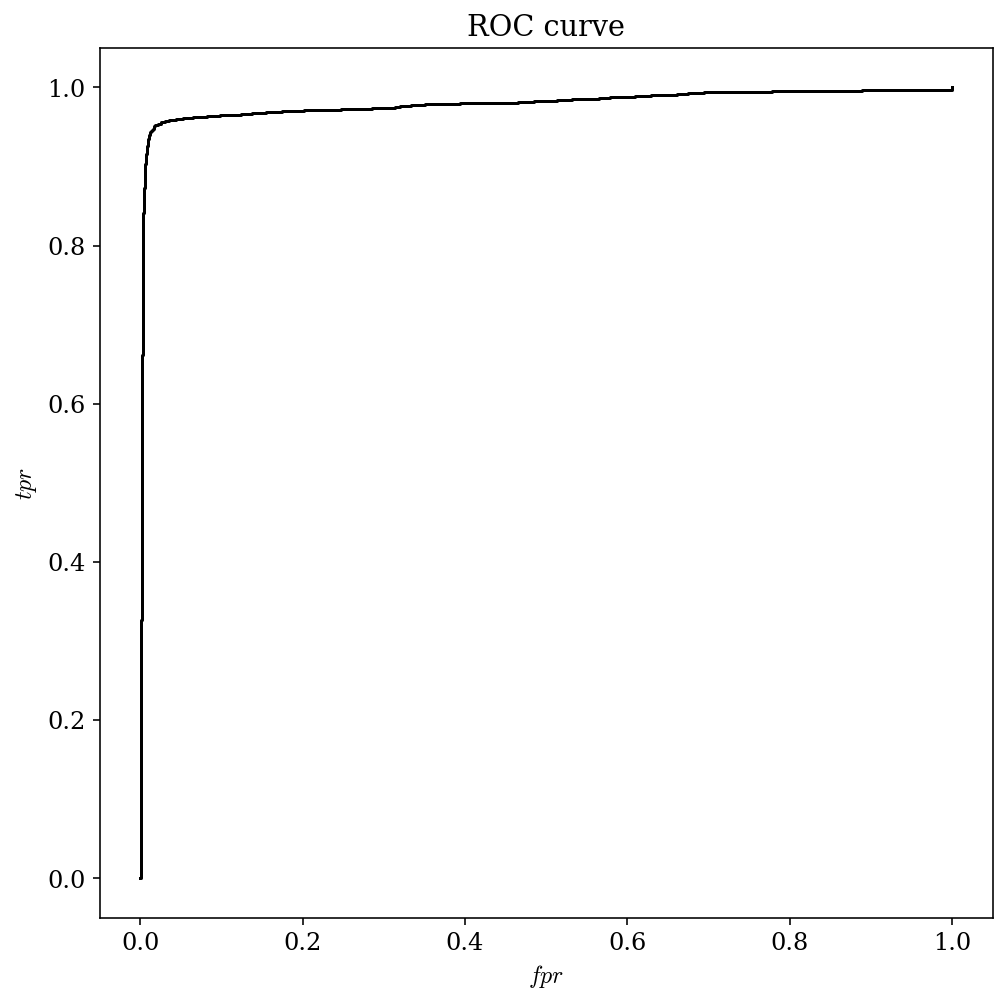

In [140]:
plt.plot(fpr, tpr, c = 'k')
plt.xlabel(r'$fpr$')
plt.ylabel(r'$tpr$')
plt.title('ROC curve')

plt.show()

In [141]:
@pickle_results('CrossVal.pkl')
def CV(keywords, colors_train, labels_train):

    now = time.time()
    
    clf = MLPClassifier(activation=keywords[0], solver=keywords[1], learning_rate=keywords[2])
    
    neurons = np.arange(10)
    learning_rates = np.linspace(0.001, 0.1, 10)
    
    grid = GridSearchCV(clf, param_grid={'hidden_layer_sizes': neurons, 'learning_rate_init':learning_rates}, cv=5, n_jobs=-1) 
    grid.fit(colors_train, labels_train)

    now = time.time() - now

    print('The process took %.i seconds' % now)

    best_rate = grid.best_params_['learning_rate_init']
    best_neurons = grid.best_params_['hidden_layer_sizes']                             
    print("best parameter choice: number of neurons = %.i, learning rate = %.3f" % (best_neurons, best_rate))
    
    return best_neurons, best_rate

In [142]:
keywords = ['relu', 'adam', 'constant']
best_neurons, best_rate = CV(keywords, colors_train, labels_train)                        

@pickle_results: using precomputed results from 'CrossVal.pkl'


In [143]:
clf_best = MLPClassifier(hidden_layer_sizes=best_neurons, activation=keywords[0], solver=keywords[1], learning_rate=keywords[2], learning_rate_init=best_rate)
clf_best.fit(colors_train, labels_train)

MLPClassifier(hidden_layer_sizes=5, learning_rate_init=0.023000000000000003)

In [144]:
labels_pred_best = clf_best.predict(colors_test)
proba_best = clf_best.predict_proba(colors_test)[:,1]
fpr_best, tpr_best, thresh_best = roc_curve(labels_test, proba_best)

In [145]:
acc_best = return_accuracy(labels_pred_best, labels_test)
accuracy.append(acc_best)
acc_best

0.9824666666666667

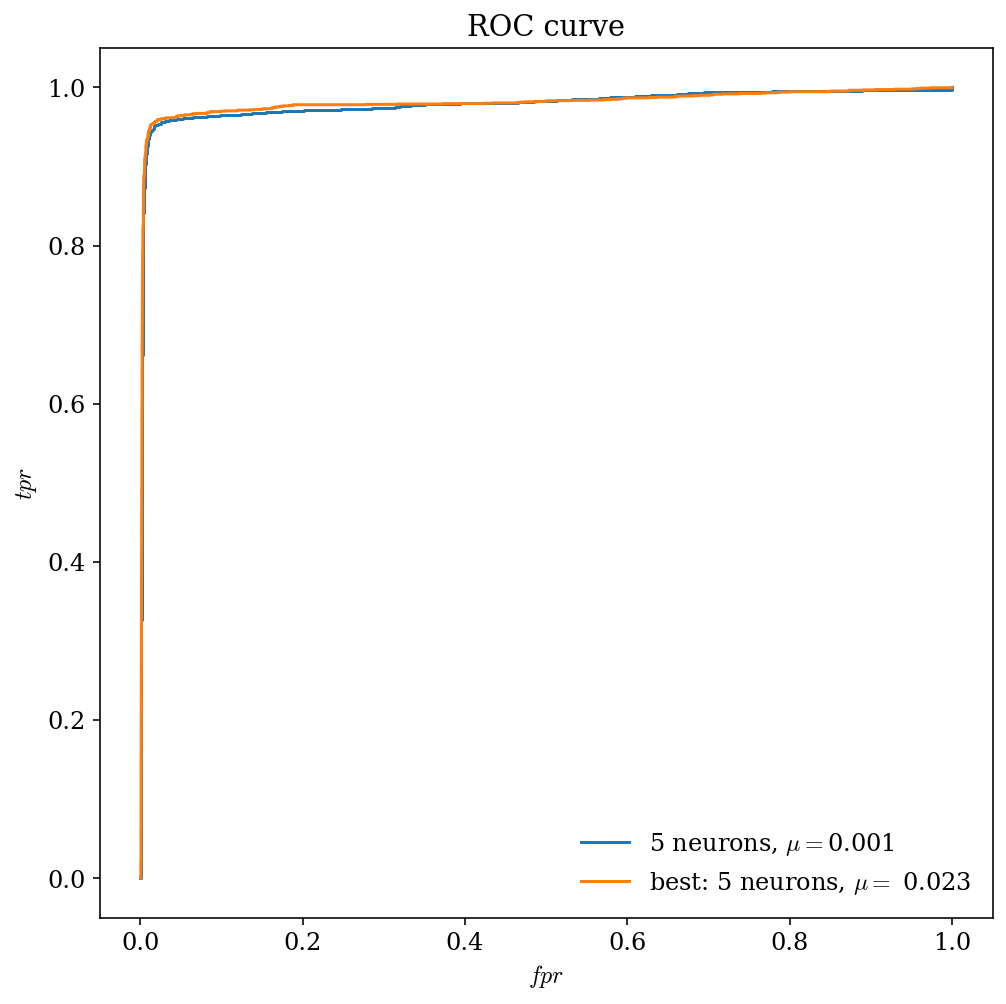

In [146]:
plt.plot(fpr, tpr, label = r'5 neurons, $\mu=$0.001')
plt.plot(fpr_best, tpr_best, label = r'best: %.i neurons, $\mu=$ %.3f' % (best_neurons, best_rate))
plt.xlabel(r'$fpr$')
plt.ylabel(r'$tpr$')
plt.title('ROC curve')

plt.legend(frameon = False)
plt.show()

### Do I need a neural network for this exercise? 
compare the roc curves, the accuracy and the boundaries with the ones of L19 (gaussian naive bayes)

In [147]:
classifiers, labels_pred, labels_proba = [], [], []
N = colors_train.shape[1] + 1
for n in range(1, N): #try with different colors
    X_train = colors_train[:,0:n]
    X_test = colors_test[:,0:n]

    clf = GaussianNB()
    clf.fit(X_train, labels_train)

    classifiers.append(clf)

    labels_pred.append(clf.predict(X_test))
    labels_proba.append(clf.predict_proba(X_test)[:,1])

In [148]:
# ROC curve
fpr_list, tpr_list, thresh_list = [], [], []

for proba in labels_proba:
    fpr_temp, tpr_temp, thresh_temp = roc_curve(labels_test, proba)
    fpr_list.append(fpr_temp)
    tpr_list.append(tpr_temp)
    thresh_list.append(thresh_temp)

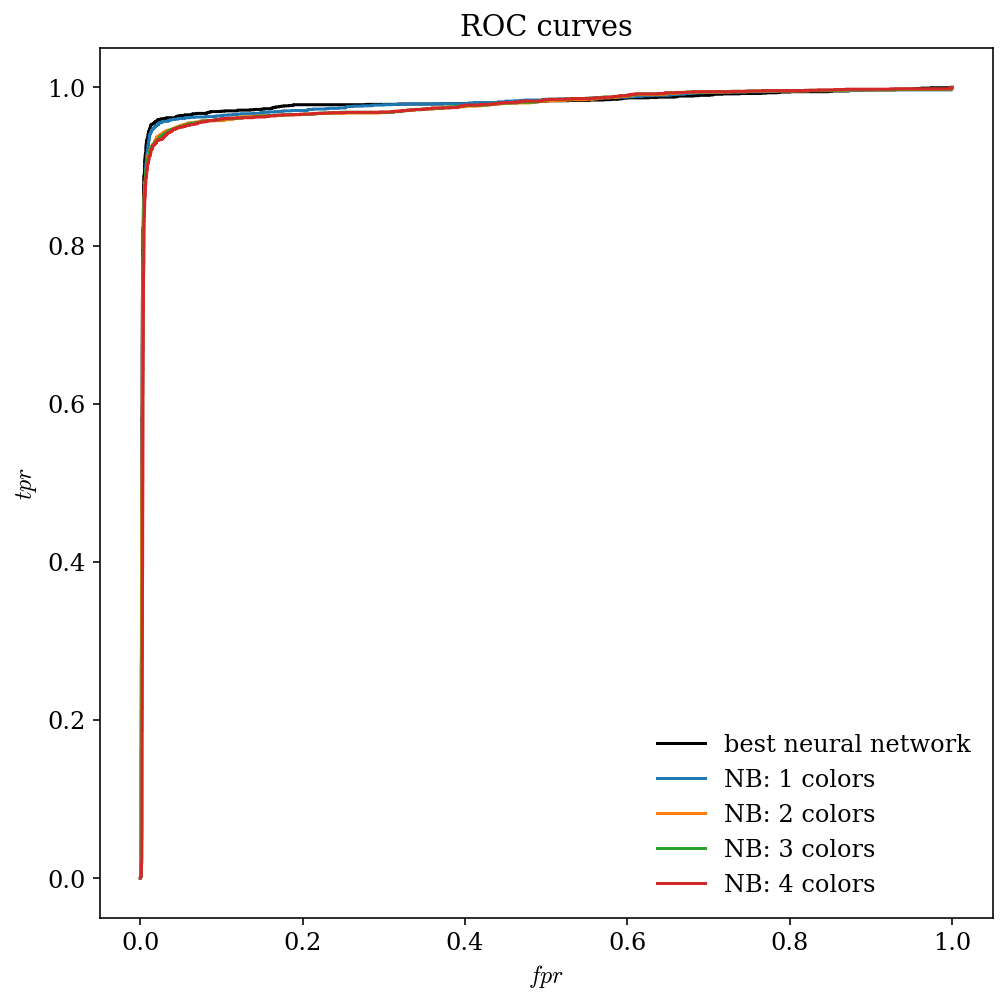

In [149]:
fig = plt.figure()

#plt.plot(fpr, tpr, '--k', label = r'5 neurons, $\mu=0.001$')
plt.plot(fpr_best, tpr_best, '-k',label = r'best neural network')

i = 1
for fpr_temp, tpr_temp in zip(fpr_list, tpr_list):
    plt.plot(fpr_temp, tpr_temp, label = 'NB: %.i colors' % i)
    i+=1


plt.xlabel(r'$fpr$')
plt.ylabel(r'$tpr$')
plt.title('ROC curves')

plt.legend(frameon = False)
plt.show()

for this exercise the two roc curves are very similar

In [150]:
accuracy_NB = []
for pred in labels_pred:
    acc = return_accuracy(pred, labels_test)
    accuracy_NB.append(acc)
accuracy.append(max(accuracy_NB))

In [151]:
methods = ['Neural network', 'Neural network with CV', 'Gaussian naive bayes']
for name, acc in zip(methods, accuracy):
    print(name + ': accuracy =', acc)

Neural network: accuracy = 0.9815333333333334
Neural network with CV: accuracy = 0.9824666666666667
Gaussian naive bayes: accuracy = 0.9814


the accuracy of the neural network is slightly higher

In [152]:
def boundary(clf, xx, yy):
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 1].reshape(xx.shape)
    
    return Z

In [153]:
X_train = colors_train[:, 0:2]

clf_nn = MLPClassifier(hidden_layer_sizes=best_neurons, activation='relu', solver='adam', learning_rate='constant', learning_rate_init=best_rate)
clf_nn.fit(X_train, labels_train)

clf_NB =  GaussianNB()
clf_NB.fit(X_train, labels_train)

clf_list = [clf_nn, clf_NB]

In [154]:
#meshgrid:
#grid for the prediction of the boundary
xlim = (min(X_train[:,0]), max(X_train[:,0]))
ylim = (min(X_train[:,1]), max(X_train[:,1]))

xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                     np.linspace(ylim[0], ylim[1], 100))

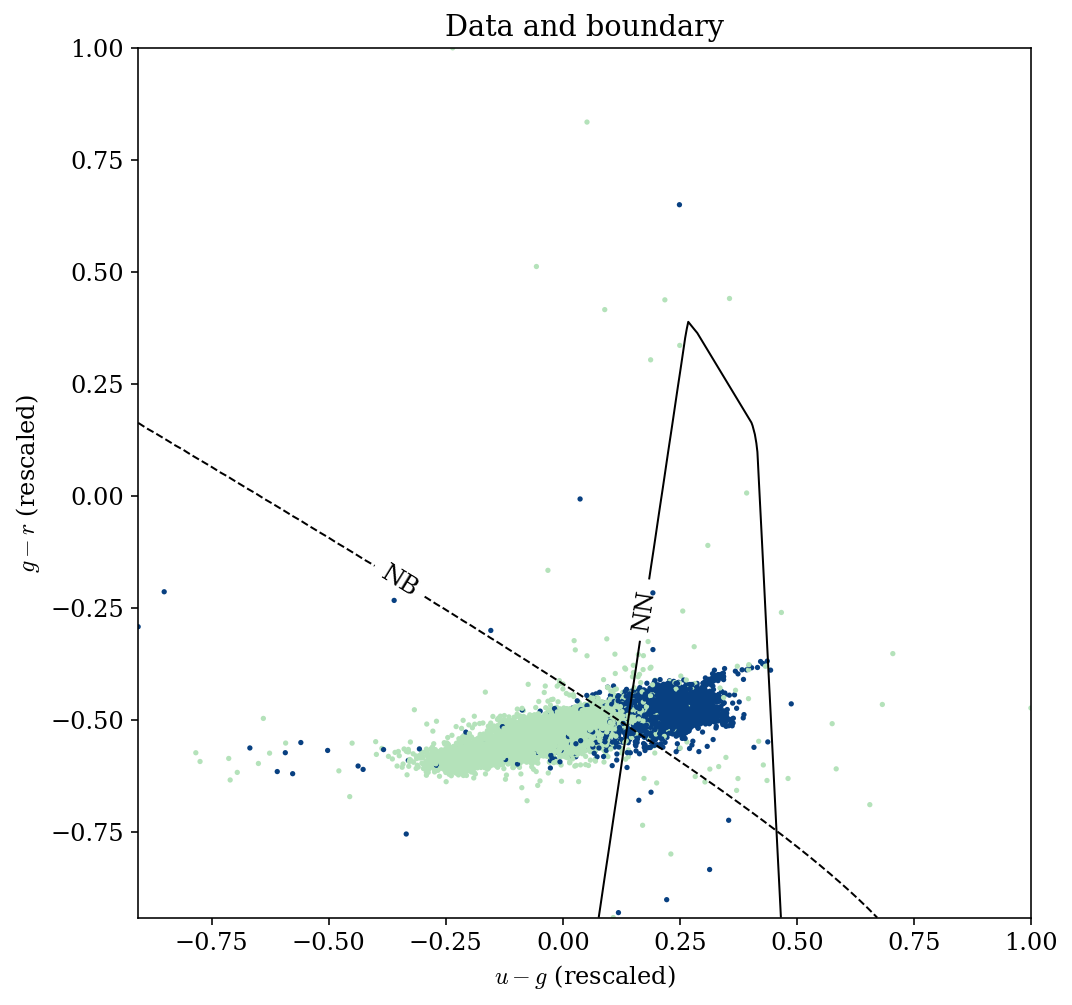

In [155]:
im = plt.scatter(X_train[:, 0], X_train[:, 1], c=labels_train,
                s=7, lw=0, cmap=plt.cm.GnBu, zorder=2)
im.set_clim(-0.5, 1)
    
ls = ['solid', 'dashed'] #linestyle
lab = ['NN', 'NB'] #labels
for clf_, line, l in zip(clf_list, ls, lab):
    Z = boundary(clf_, xx, yy)
    C = plt.contour(xx, yy, Z, [0.5], colors='k', linestyles=line, linewidths = 1)
    plt.clabel(C, fmt=l)

plt.xlim(xlim)
plt.ylim(ylim)

plt.xlabel(r'$u-g$ (rescaled)')
plt.ylabel(r'$g-r$ (rescaled)')
plt.title('Data and boundary')
plt.show()